In [115]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
from collections import Counter
from sklearn.metrics import confusion_matrix

from statsmodels.formula.api import logit
from statsmodels.api import Logit

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Logistic Regression

Let us recall from previous lecture that regression tasks are special examples of supervised learning algorithms where the independent variables and dependent variables are both numerical and the model has the shape

$$ y_i \approx \beta x_i + \alpha + \epsilon $$

where $\alpha$ and $\beta$ are constants to be determined and $\epsilon \sim N(0,\sigma)$.

There are, however, some assumptions that we do not mention often:

1. $x_i$'s are real random vectors.
2. $y_i$'s are real numbers that can be both negative and positive.

But what happens if we relax the second condition. One such common case is when $y_i$'s are not real random variable but binary categorical variable such as YES or NO.


## Underlying assumption

Assume we have a collection of data points $(x_i,y_i)$ where $x_i\in\mathbb{R}^n$ and $y_i\in\{0,1\}$. Now, assume that there is a hyper-plane $P$ that separates points $x_i$ whose $y_i=0$, and points $x_i$ whose $y_i=1$. Any such hyper-plane $P$ has the equation $ n\cdot \mathbf{x} + b = 0 $ where $n$ is the normal vector of the hyper-plane and $b$ is the displacement.


> Question: We know that such hyper-planes divide $\mathbb{R}^n$ into 2 pieces. Given a point $\mathbf{x}$ in $\mathbb{R}^n$, how can we figure out which side of the hyperplane $P$ it resides?


## The logistic function

We need a function that exaggerate negative and positive values. Something that converges to 0 fast the negative $x$-axis, and something that converges to 1 fast on the positive $x$-axis. [The logistic function]() does exactly that

$$ \sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}} $$




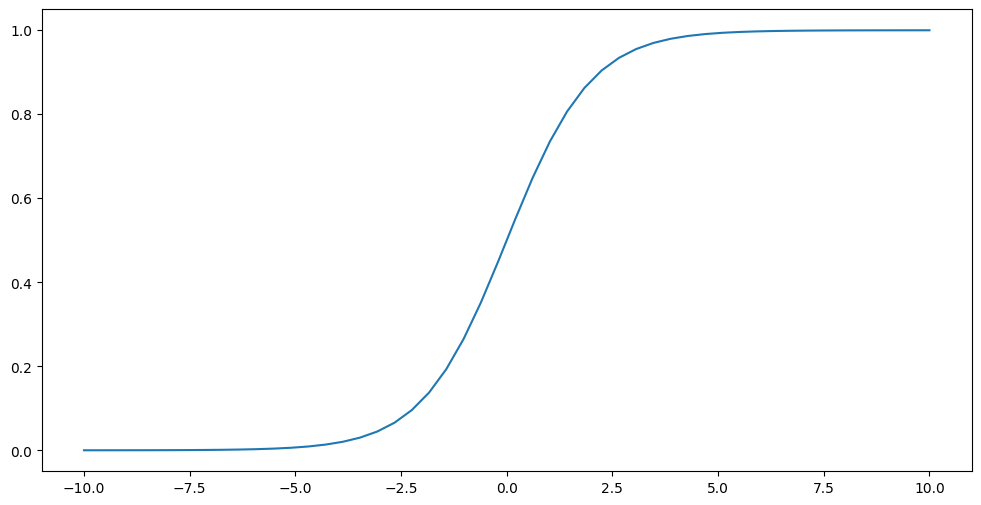

In [2]:
xs = np.linspace(-10,10,50)
ys = 1/(1+np.exp(-xs))
plt.figure(figsize=(12,6))
plt.plot(xs,ys)

## Logistic Regression

Let us say that the probability of a point ${\mathbf x}$ being on the positive side of the hyper-plane ${\mathbf n}\cdot {\mathbf x}+b=0$ is 

$$\frac{1}{1+e^{-{\mathbf n}\cdot {\mathbf x} - b}}$$

Using this we can write a probability function $p({\mathbf x},y)$ that a point ${\mathbf x}$ having $y$ as the response as follows:

$$p({\mathbf x},y) = \left(\frac{1}{1+e^{-{\mathbf n}\cdot {\mathbf x} - b}}\right)^y \left(\frac{1}{1+e^{{\mathbf n}\cdot {\mathbf x} + b}}\right)^{1-y} $$
which measures the probability of ${\mathbf x}$ being on the right side where $y$ takes values 0 or 1.  Then the probability that all of the points in our dataset being on the right side is 

$$ p(D) = \prod_{i=1}^n p(x_i,y_i) $$ 

and therefore we would like to maximize $p(D)$ depending on the unknown parameters ${\mathbf n}\in\mathbb{R}^n$ and $b$. Instead one can minimize the following function 

$$ LE({\mathbf n},b) = -\frac{1}{n}\sum_{i=1}^n y_i\log(1+e^{-{\mathbf n}\cdot x_i - b}) + (1-y_i)\log(1+e^{{\mathbf n}\cdot x_i + b}) $$ 

which is just the natural logarithm of $p(D)$. Then the best-fitting ${\mathbf n}$ and $b$ is given by 

$$ \text{argmin}_{{\mathbf n,b}} LE({\mathbf n},b) $$



## An Example

Here is a simple example. We are going to consider the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris):

In [3]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.columns = ['a','b','c','d','p']
iris

,a,b,c,d,p
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [93]:
X = iris.iloc[:,:4]
y = iris.iloc[:,4]

encoder = OneHotEncoder(sparse=False)
yy = encoder.fit_transform(np.array(y).reshape(-1,1))

In [94]:
res = pd.concat([X,pd.DataFrame(yy)],axis=1)
res.columns = ['a','b','c','d','p1','p2','p3']
res

model = logit('p2 ~ a + b + c + d', data=res).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.485883
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     p2   No. Observations:                  150
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Oct 2022   Pseudo R-squ.:                  0.2367
Time:                        19:20:09   Log-Likelihood:                -72.882
converged:                       True   LL-Null:                       -95.477
Covariance Type:            nonrobust   LLR p-value:                 3.631e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3229      2.498      2.932      0.003       2.427      12.219
a             -0.2527      0.649     -0.389      0.697      -1.526       1.020
b             -2.7794      0.786     -3.537      0.000      -4.320      -1.239
c              1.2993      0.682      1.904      0.057      -0.038       2.637
d             -2.7043      1.163     -2.326      0.020      -4.983      -0.426
==============================================================================
"""

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)

model = LogisticRegression(max_iter=1500)
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
y_predict = model.predict(X_test)
confusion_matrix(y_test,y_predict)

0.9210526315789473


array([[11,  0,  0],
       [ 0, 14,  2],
       [ 0,  1, 10]])

In [96]:
def bootstrap(X,y,model):
    res = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)
        model.fit(X_train,y_train)
        res.append(model.score(X_test,y_test))
    tmp = sorted(res)[3:97]
    return (min(tmp),max(tmp))

In [97]:
bootstrap(X,y,model)

(0.8947368421052632, 1.0)

## Another Example

In [98]:
with urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip') as url:
    zf = ZipFile(BytesIO(url.read()))
    air = pd.read_csv(zf.open('AirQualityUCI.csv'),sep=';',decimal=',')

del air['Unnamed: 15'],air['Unnamed: 16']
air.dropna(inplace=True)
air

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


In [99]:
y = air['T'].astype(float) >= 20
X = air[['CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','RH','AH']]

In [100]:
model = LogisticRegression(max_iter=1500)
bootstrap(X,y,model)

(0.9854700854700855, 0.9935897435897436)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)

model = LogisticRegression(max_iter=1500)
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
y_predict = model.predict(X_test)
confusion_matrix(y_test,y_predict)

0.9867521367521368


array([[1396,   18],
       [  13,  913]])

## Yet Another Example


In [61]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')
data

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


In [102]:
X = data[['APM','SelectByHotkeys','AssignToHotkeys','MinimapAttacks','MinimapRightClicks',
          'NumberOfPACs','GapBetweenPACs','ActionLatency','ActionsInPAC','WorkersMade',
          'ComplexUnitsMade','ComplexAbilitiesUsed']]
y = data['LeagueIndex'] == 1

In [103]:
model = LogisticRegression(max_iter=1500)
bootstrap(X,y,model)

(0.9422850412249706, 0.9634864546525324)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)

model = LogisticRegression(max_iter=1500)
model.fit(X_train,y_train)

y_predict = model.predict(X_test)
confusion_matrix(y_test,y_predict)

array([[803,   6],
       [ 31,   9]])

# Locally Constant Regression

We switch gears and return to our original setup $(x_i,y_i)$ where $x_i\in\mathbb{R}^n$ and $y_i\in\mathbb{R}$. However, instead of using a linear model such as $y \approx \beta\cdot x + b$ we are going to use locally constant functions. For this purpose let $a<b$ and define

$$ \chi_{[a,b]}(x) =
   \begin{cases}
      1 & \text{ if } a\leq x\leq b\\
      0 & \text{ otherwise.}
   \end{cases} $$
   
Now, we need to determine best choices of subintervals $I = a_1\leq b_1\leq a_2\leq b_2\leq \cdots \leq a_m\leq b_m$ and constants $\lambda = \lambda_1\leq\cdots\leq \lambda_m$ such that

$$ y_i \approx \sum_{i=1}^m \lambda_i \chi_{[a_i,b_1]}(x_i) $$

We use the same error function

$$ Err(I,\lambda) = \sum_{i=1}^N (y_i - f(x_i))^2 $$

We need find the parameters $I$ and $\lambda$ making the error function minimal.

## An example

In [107]:
data = pd.read_csv('https://www.saedsayad.com/datasets/slump.txt',sep='\t')
data

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82
...,...,...,...,...,...,...,...,...,...,...
98,248.3,101.0,239.1,168.9,7.7,954.2,640.6,0.0,20.0,49.97
99,248.0,101.0,239.9,169.1,7.7,949.9,644.1,2.0,20.0,50.23
100,258.8,88.0,239.6,175.3,7.6,938.9,646.0,0.0,20.0,50.50
101,297.1,40.9,239.9,194.0,7.5,908.9,651.8,27.5,67.0,49.17


In [111]:
X = data[['Cement','Slag','Fly ash','Water','SP','Coarse Aggr.', 'Fine Aggr.', 'SLUMP(cm)','FLOW(cm)']]
y = data['Compressive Strength (28-day)(Mpa)']

model = DecisionTreeRegressor()
bootstrap(X,y,model)

(0.28123511160384596, 0.8234337403640168)

In [116]:
model = LinearRegression()
bootstrap(X,y,model)

(0.7503269290786796, 0.9403120450675231)

## Another Example

In [129]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat',sep='\t',header=None)
data

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [134]:
X = data.iloc[:,:5]
y = data.iloc[:,5]
model = DecisionTreeRegressor()
bootstrap(X,y,model)

(0.8141929349462244, 0.8961265756962631)